<a href="https://colab.research.google.com/github/tnfru/abstraction_and_reasoning/blob/master/ARC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/tnfru/abstraction_and_reasoning/master/data_utils.py -P local_modules -nc
import sys
sys.path.append('local_modules')

--2020-03-26 15:30:23--  https://raw.githubusercontent.com/tnfru/abstraction_and_reasoning/master/data_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2751 (2.7K) [text/plain]
Saving to: ‘local_modules/data_utils.py’

data_utils.py       100%[===================>]   2.69K  --.-KB/s    in 0s      

2020-03-26 15:30:23 (77.8 MB/s) - ‘local_modules/data_utils.py’ saved [2751/2751]



In [2]:
import os, json
import json
from google_drive_downloader import GoogleDriveDownloader as gdd
import numpy as np
from matplotlib import pyplot as plt

if 'google.colab' in sys.modules:
  %tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Input
from tensorflow.keras import Sequential

import data_utils
from data_utils import plot_task, plot_prediction, inp2img

TensorFlow 2.x selected.


## Set up hardware

In [5]:
gpus = tf.config.experimental.list_logical_devices("GPU")

if len(gpus) > 0:
  strategy = tf.distribute.MirroredStrategy(gpus)
  print('Running on ', len(gpus), ' GPU(s) ')
else:
  strategy = tf.distribute.get_strategy()
  print('Running on CPU')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Running on  1  GPU(s) 


# Read Data

In [6]:
gdd.download_file_from_google_drive(file_id='1FUk30rXuym1RygfaDq4g-Uj-CkkG63IE',
                                    dest_path='./data/arc.zip',
                                    unzip=True)


Unzipping...Done.


In [7]:
train_tasks, val_tasks, test_tasks = data_utils.get_task_sets()

len(train_tasks), len(val_tasks), len(test_tasks)

(400, 400, 100)

## Visualize some tasks

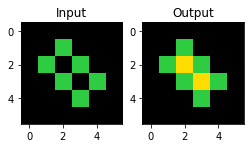

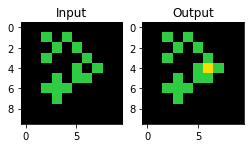

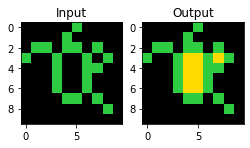

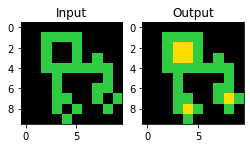

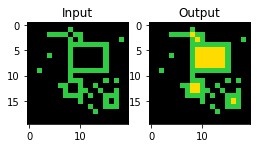

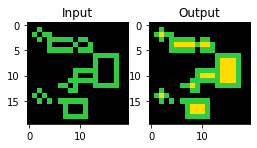

In [8]:
plot_task(train_tasks[1])

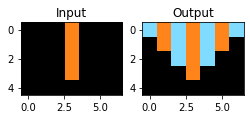

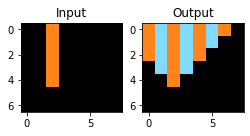

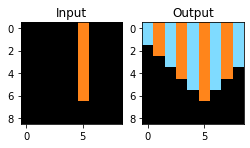

In [9]:
plot_task(train_tasks[347])

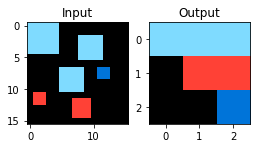

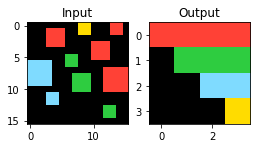

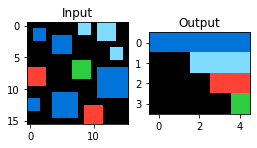

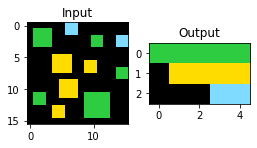

In [10]:
plot_task(val_tasks[65])

### View how training examples are structurized

In [11]:
train_tasks[1]['train'][0]

{'input': [[0, 0, 0, 0, 0, 0],
  [0, 0, 3, 0, 0, 0],
  [0, 3, 0, 3, 0, 0],
  [0, 0, 3, 0, 3, 0],
  [0, 0, 0, 3, 0, 0],
  [0, 0, 0, 0, 0, 0]],
 'output': [[0, 0, 0, 0, 0, 0],
  [0, 0, 3, 0, 0, 0],
  [0, 3, 4, 3, 0, 0],
  [0, 0, 3, 4, 3, 0],
  [0, 0, 0, 3, 0, 0],
  [0, 0, 0, 0, 0, 0]]}

In [12]:
print("Number of equal input and output shapes in train:", data_utils.count_equal_dims(train_tasks))
print("Number of equal input and output shapes in val:", data_utils.count_equal_dims(val_tasks))
print("Number of equal input and output shapes in test:", data_utils.count_equal_dims(test_tasks, isTrain=False))

Number of equal input and output shapes in train: 262
Number of equal input and output shapes in val: 270
Number of equal input and output shapes in test: 65


# Cellular Automata

For every problem where the input shape is equal to the output shape we can use a Cellular Automata for the transformation.

I want to thank [arseny-n](kaggle.com/arsenynerinovsky/cellular-automata-as-a-language-for-reasoning ) for introducing cellular automata to this problem set.

This notebook is an implementation of [teddykokers PyTorch CA](https://www.kaggle.com/teddykoker/training-cellular-automata-part-i-game-of-life) in tensorflow. I really like the the architecture teddy suggested.


## Define Model

In [0]:
def get_model():
  inputs = Input(shape=(None, None, 10))
  x = Conv2D(128, 3, padding='same')(inputs)
 # x = BatchNormalization(momentum=0.5)(x)
  x = Activation('relu')(x)
  x = Conv2D(10, 1)(x)
  outputs = tf.keras.activations.softmax(x, axis=3)

  return tf.keras.Model(inputs=inputs, outputs=outputs)

In [0]:
def solve_task(task, max_steps=10):
  model = get_model()
  epochs = 100
  losses = []
  
  loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

  for num_steps in range(1, max_steps):
    optimizer = tf.keras.optimizers.Adam(learning_rate=(np.abs(0.1/np.exp(num_steps))))

    for epoch in range(epochs):
      loss = 0.0

      for sample in task:
        with tf.GradientTape() as tape:
          # predict output from input

          x = inp2img(sample['input'])
          y = tf.convert_to_tensor(sample['output'], dtype=tf.int8)

          y_pred = model(tf.keras.activations.softmax(x, axis=3))
          
          for _ in range(num_steps):
            y_pred = model(y_pred)

          loss += loss_fn(y, y_pred)

          # predict output from output to force stabilization

          y_pred = model(inp2img(sample['output']))

          loss += 5 * loss_fn(y, y_pred)

        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
      
      losses.append(loss)
  
  return model, np.array(losses)

In [0]:
def predict(model, task, num_steps=100):
  predictions = []

  for sample in task:
    x = inp2img(sample['input'])
    pred = model(tf.keras.activations.softmax(x, axis=3))
    
    for _ in range(num_steps):
      pred = model(pred)
    
    predictions.append(tf.argmax(pred, axis=3).numpy().squeeze())
  return predictions

In [0]:
def train_and_plot(task, max_steps=10):
  model, losses = solve_task(task['train'], max_steps=max_steps)
  plt.plot(losses)
  predictions = predict(model, task['train'])
  plot_prediction(predictions, task['train'])
  predictions = predict(model, task['test'])
  plot_prediction(predictions, task['test'])

In [0]:
def benchmark(task_ids = [1, 347, 26, 32], max_steps=2):
  for i in task_ids:
    train_and_plot(train_tasks[i], max_steps=max_steps)

## Vizualize results

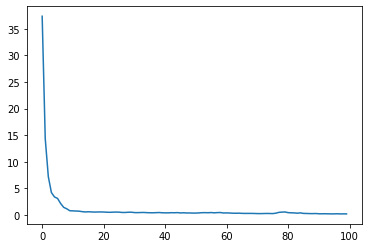

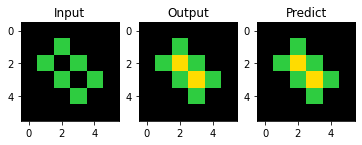

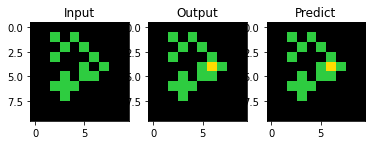

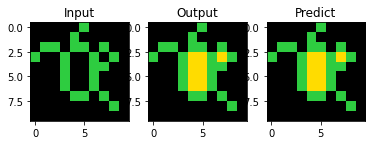

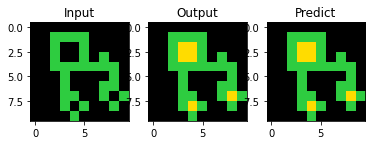

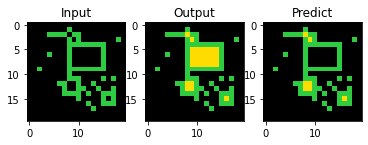

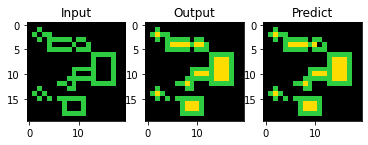

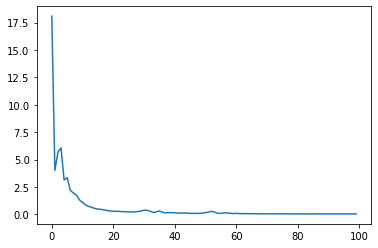

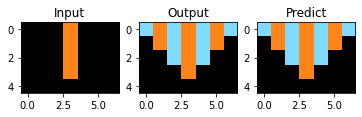

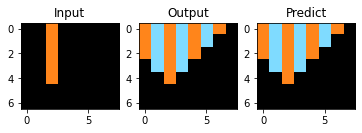

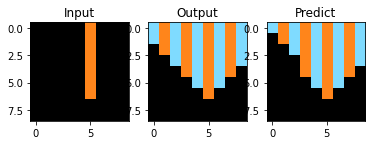

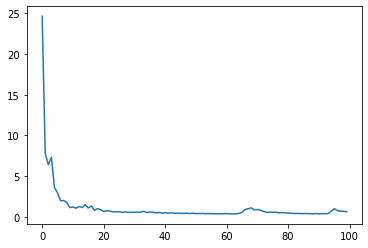

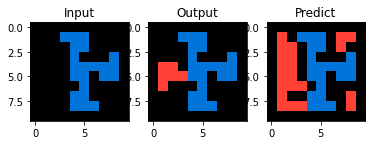

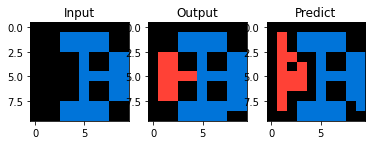

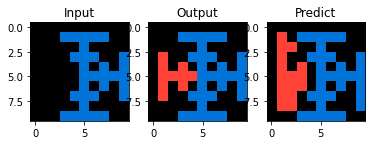

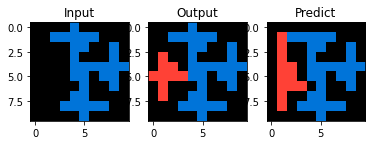

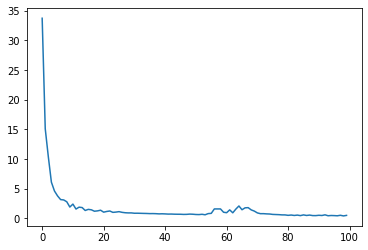

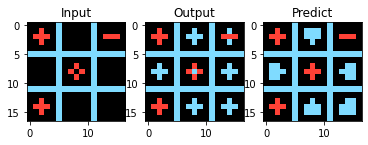

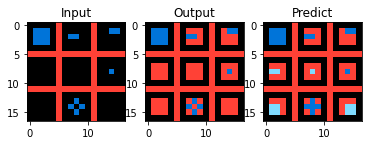

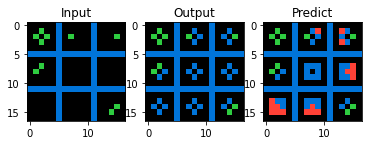

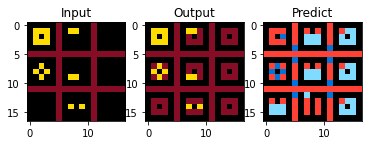

In [20]:
benchmark()